# Retrieve sensor log from Raspberry Pi and graph it

In [1]:
# read raspberry pi access data from secrets file
# Add path to my library
import sys
sys.path.append(r'/Users/alvazi2/Documents/PythonPrograms/AlvaziLib')
import Secrets
PATH = "/Users/alvazi2/Documents/JupyterLab/Secrets/"
SECRETS_FILENAME = "AlvaziSecrets.json"
secrets = Secrets.AlvaziSecrets(PATH, SECRETS_FILENAME)

In [2]:
from platform import python_version
print(python_version())

3.10.4


In [3]:
from paramiko import SSHClient
from scp import SCPClient

RaspberryPi = secrets.secret("Raspberry Pi 2013")["IP"]
MyUser = secrets.secret("Raspberry Pi 2013")["USER"]
MyPassword = secrets.secret("Raspberry Pi 2013")["PASSWORD"]
RemotePath = 'Adafruit_Python_BMP/'
LogFile = 'sensor_log.csv'

# copy sensor log from my Raspberry Pi
ssh = SSHClient() #secure shell SSH connection
ssh.load_system_host_keys()
ssh.connect(RaspberryPi, username=MyUser, password=MyPassword, look_for_keys=False)
scp = SCPClient(ssh.get_transport())
scp.get(RemotePath+LogFile)
scp.close()

In [4]:
# read sensor log file (CSV format) into pandas dataframe object
from pandas import read_csv, to_datetime, DataFrame, Timestamp
sensorLog = read_csv(LogFile, index_col=0, parse_dates=True)
# round timestamp to full minutes
sensorLog.index = to_datetime(sensorLog.index.map(lambda t: t.strftime('%Y-%m-%d %H:%M')))
# print most recent 10 sensor log entries
sensorLog.tail(10)

,Temp,Pressure,Altitude,Sealevel Pressure
TimeStamp,,,,
2023-01-16 14:45:00,13.2,100109.0,101.48,100102.0
2023-01-16 15:00:00,13.2,100098.0,102.24,100106.0
2023-01-16 15:15:00,13.2,100133.0,99.97,100130.0
2023-01-16 15:30:00,13.3,100140.0,99.38,100136.0
2023-01-16 15:45:00,13.4,100166.0,97.45,100164.0
2023-01-16 16:00:00,13.2,100167.0,96.35,100176.0
2023-01-16 16:15:00,13.3,100194.0,94.76,100191.0
2023-01-16 16:30:00,13.1,100205.0,93.33,100216.0
2023-01-16 16:45:00,13.0,100215.0,92.74,100222.0


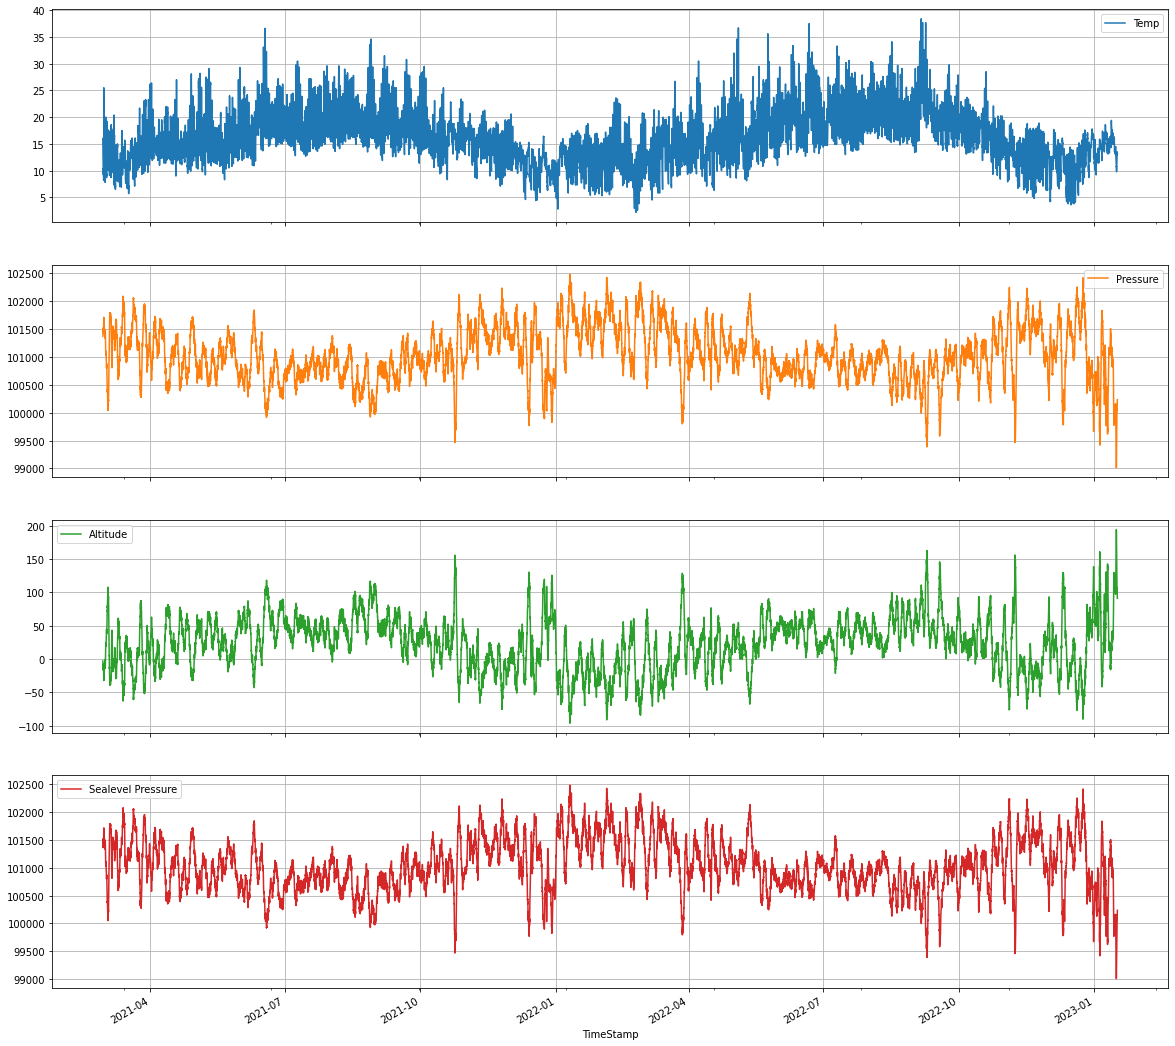

In [5]:
import matplotlib.pyplot as plt

# plot all data columns
axs = sensorLog.plot(figsize=(20,20), grid=True, subplots=True)

2023-01-21


/var/folders/lb/zkztxsfn3t1d5gpq36g3b9n00000gn/T/ipykernel_42970/706050495.py:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  axs = sensorLog.loc[today:today].plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, marker='o', subplots=True)


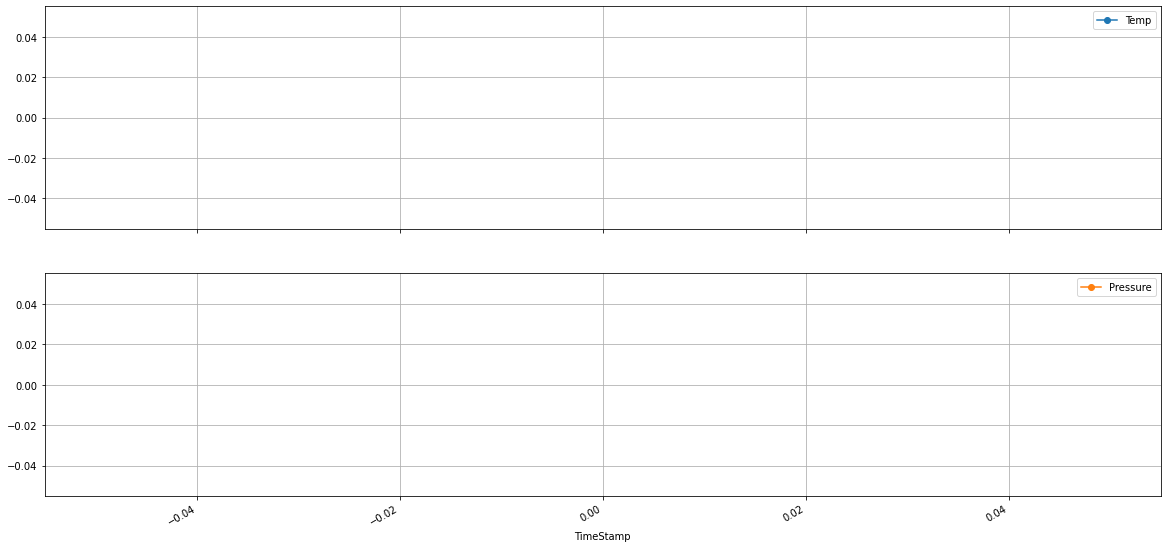

In [6]:
import datetime
today = datetime.date.today().isoformat()
print(today)
# plot today's temperature and pressure
axs = sensorLog.loc[today:today].plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, marker='o', subplots=True)

In [7]:
print(sensorLog.loc[today:today].describe())

       Temp  Pressure  Altitude  Sealevel Pressure
count   0.0       0.0       0.0                0.0
mean    NaN       NaN       NaN                NaN
std     NaN       NaN       NaN                NaN
min     NaN       NaN       NaN                NaN
25%     NaN       NaN       NaN                NaN
50%     NaN       NaN       NaN                NaN
75%     NaN       NaN       NaN                NaN
max     NaN       NaN       NaN                NaN


/var/folders/lb/zkztxsfn3t1d5gpq36g3b9n00000gn/T/ipykernel_42970/1384844168.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  print(sensorLog.loc[today:today].describe())


/var/folders/lb/zkztxsfn3t1d5gpq36g3b9n00000gn/T/ipykernel_42970/952940987.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  axs = sensorLog.loc[yesterday:today].plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, marker='.', subplots=True)


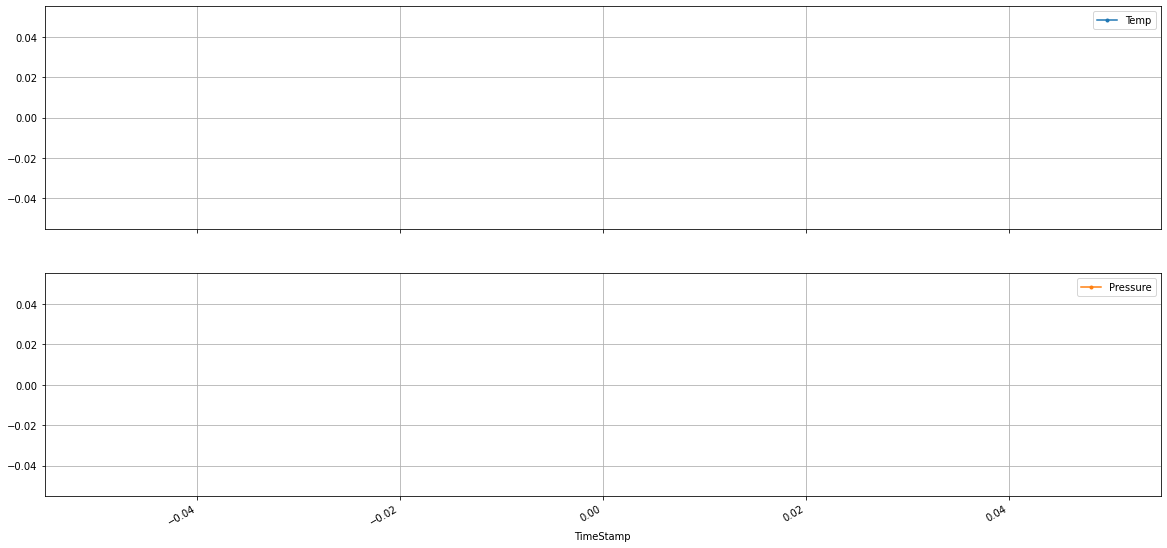

In [8]:
# plot yesterday's and today's temperature and pressure
yesterday = (datetime.date.today() - datetime.timedelta(days = 1)).isoformat()
axs = sensorLog.loc[yesterday:today].plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, marker='.', subplots=True)

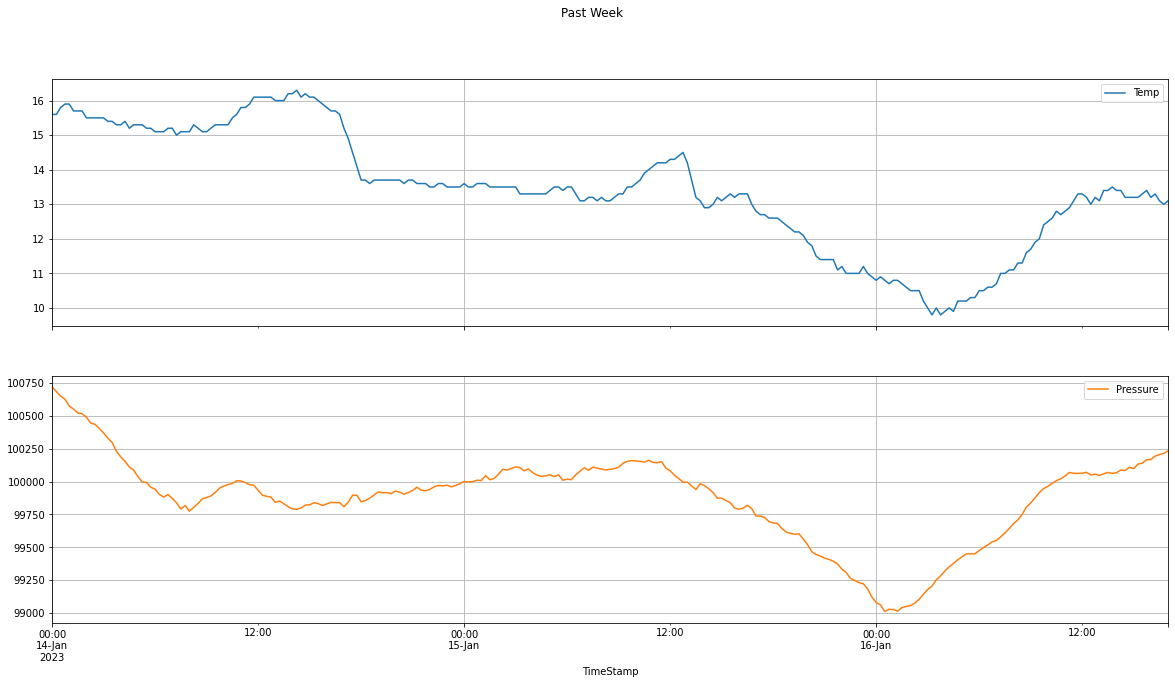

In [9]:
# plot past week's temperature and pressure
weekago = (datetime.date.today() - datetime.timedelta(weeks = 1)).isoformat() 
axs = sensorLog.loc[weekago:today].plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True, title='Past Week')
# save plot as file
plt.savefig('pastWeekPlot')

In [10]:
sensorLog.axes

[DatetimeIndex(['2021-02-27 17:03:00', '2021-02-27 17:15:00',
                '2021-02-27 17:30:00', '2021-02-27 17:45:00',
                '2021-02-27 18:00:00', '2021-02-27 18:15:00',
                '2021-02-27 18:30:00', '2021-02-27 18:45:00',
                '2021-02-27 19:00:00', '2021-02-27 19:15:00',
                ...
                '2023-01-16 14:45:00', '2023-01-16 15:00:00',
                '2023-01-16 15:15:00', '2023-01-16 15:30:00',
                '2023-01-16 15:45:00', '2023-01-16 16:00:00',
                '2023-01-16 16:15:00', '2023-01-16 16:30:00',
                '2023-01-16 16:45:00', '2023-01-16 17:00:00'],
               dtype='datetime64[ns]', name='TimeStamp', length=66027, freq=None),
 Index(['Temp', 'Pressure', 'Altitude', 'Sealevel Pressure'], dtype='object')]

In [11]:
sensorLog.loc[weekago:today].agg(['min', 'max', 'mean'])

,Temp,Pressure,Altitude,Sealevel Pressure
min,9.800000,99013.00000,50.740000,99007.00000
max,16.300000,100721.00000,193.860000,100717.00000
mean,13.410345,99871.40613,121.626628,99873.43295


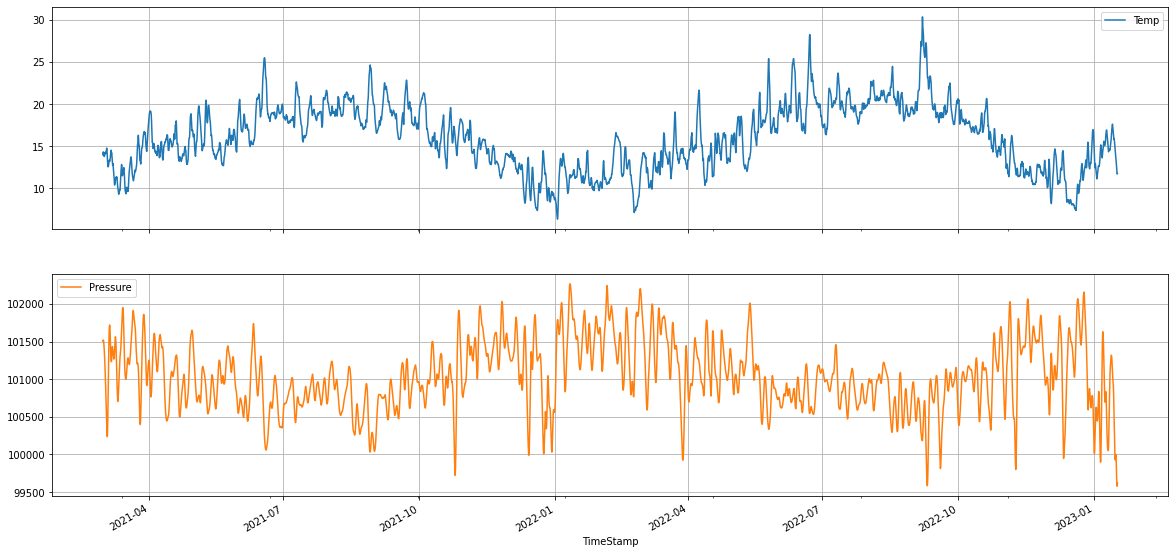

In [12]:
# 1-day rolling average
axs = sensorLog.rolling(24*4).mean().plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True)

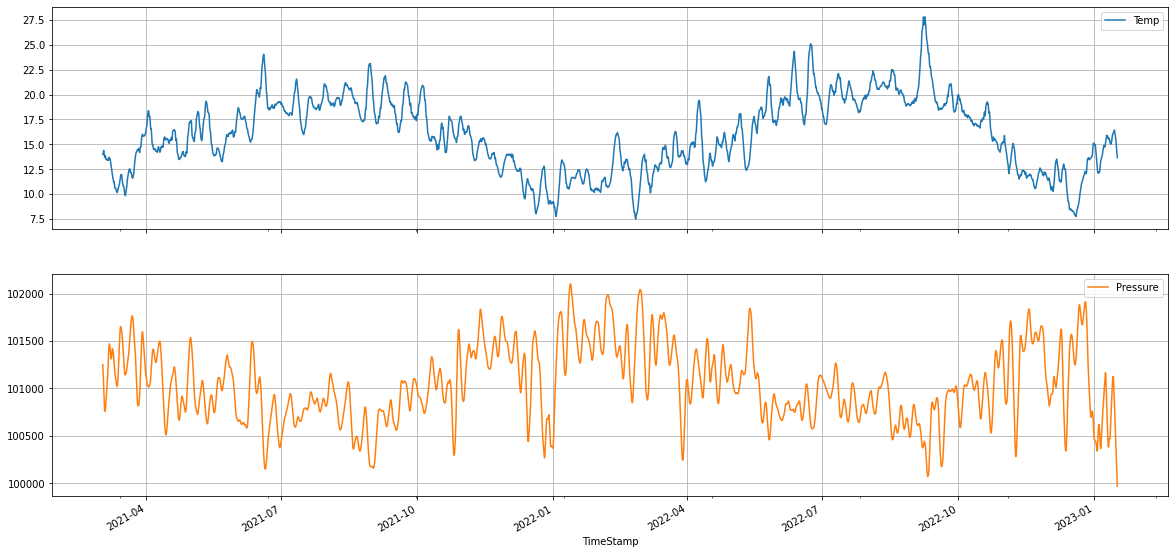

In [13]:
# 3 days rolling average
axs = sensorLog.rolling(3*24*4).mean().plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True)

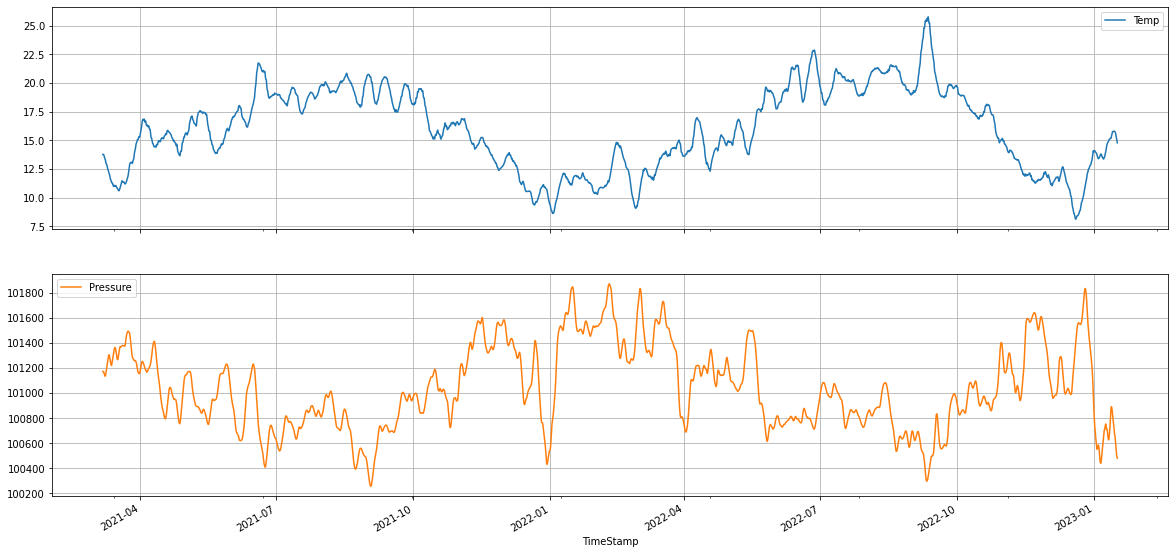

In [14]:
# 7 days rolling average
axs = sensorLog.rolling(7*24*4).mean().plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True)

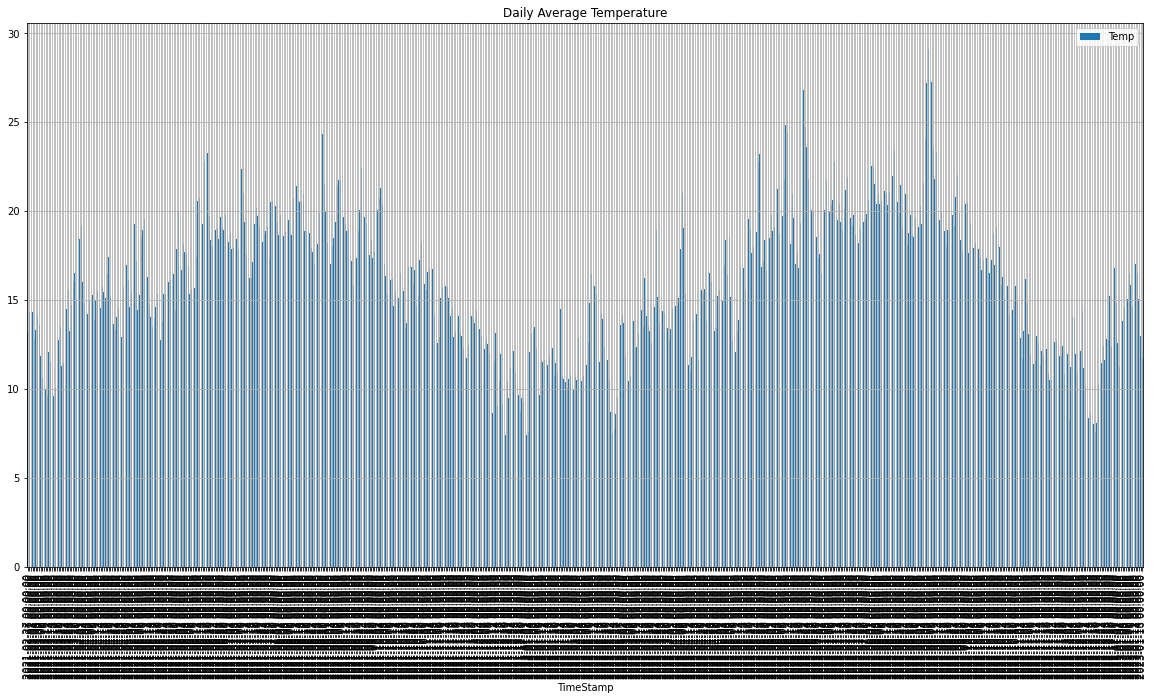

In [15]:
axs = sensorLog.resample('D', level=0).mean().plot.bar(title='Daily Average Temperature',
    y=['Temp'], figsize=(20,10), grid=True)

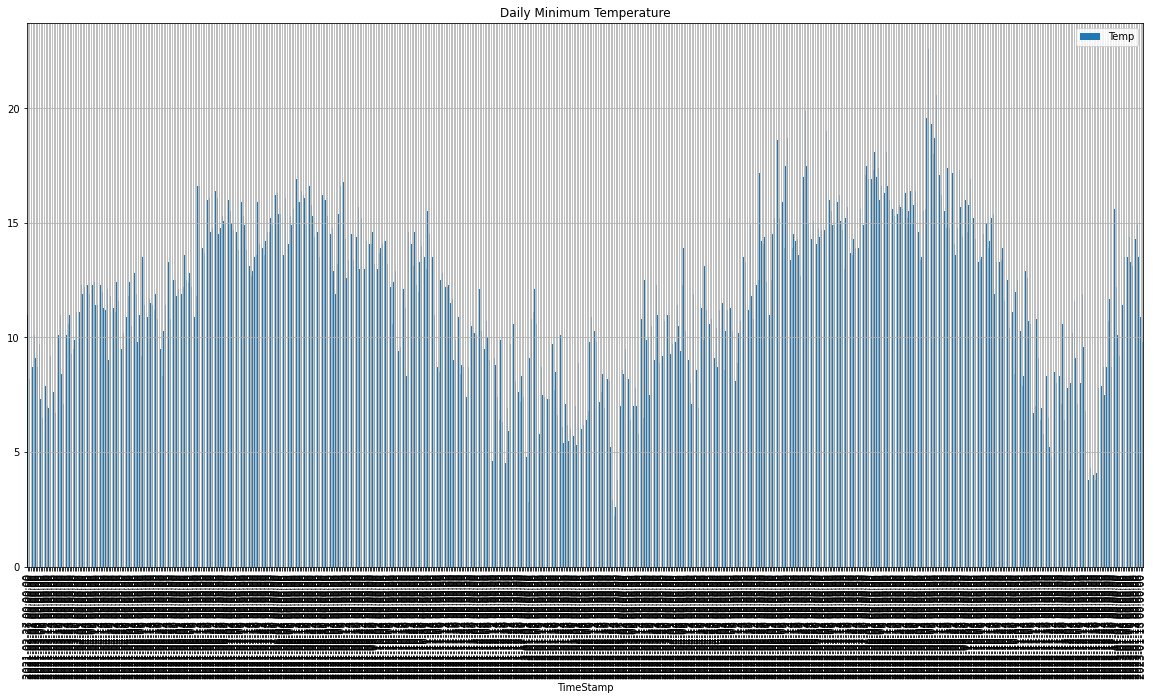

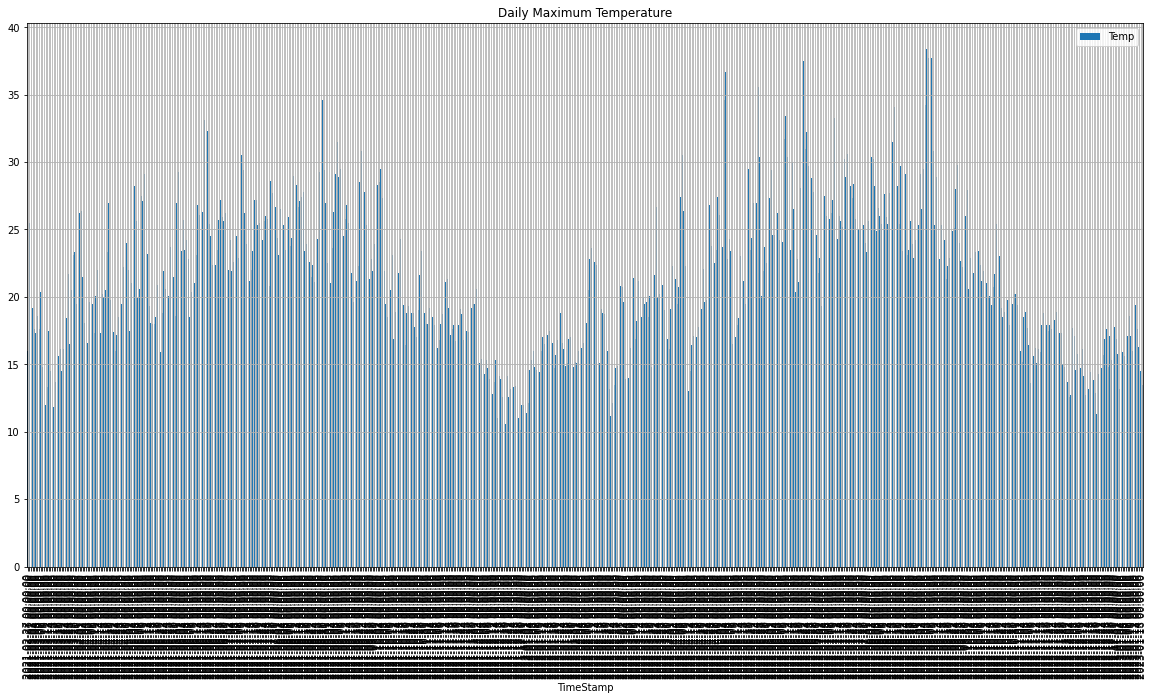

In [16]:
axs1 = sensorLog.resample('D', level=0).min().plot.bar(
    y=['Temp'], figsize=(20,10), grid=True, title='Daily Minimum Temperature')
axs2 = sensorLog.resample('D', level=0).max().plot.bar(
    y=['Temp'], figsize=(20,10), grid=True, title='Daily Maximum Temperature')

In [17]:
# calculate daily min, mean, max temperature using dataframe resampling
minTemp = sensorLog.loc[:yesterday].resample('D', level=0).min().filter(items=['TimeStamp','Temp']).rename(columns = {'Temp':'Min'})
meanTemp = sensorLog.loc[:yesterday].resample('D', level=0).mean().filter(items=['TimeStamp','Temp']).rename(columns = {'Temp':'Mean'})
maxTemp = sensorLog.loc[:yesterday].resample('D', level=0).max().filter(items=['TimeStamp','Temp']).rename(columns = {'Temp':'Max'})
dailyTemp = minTemp.join(meanTemp, how='outer').join(maxTemp, how='outer')

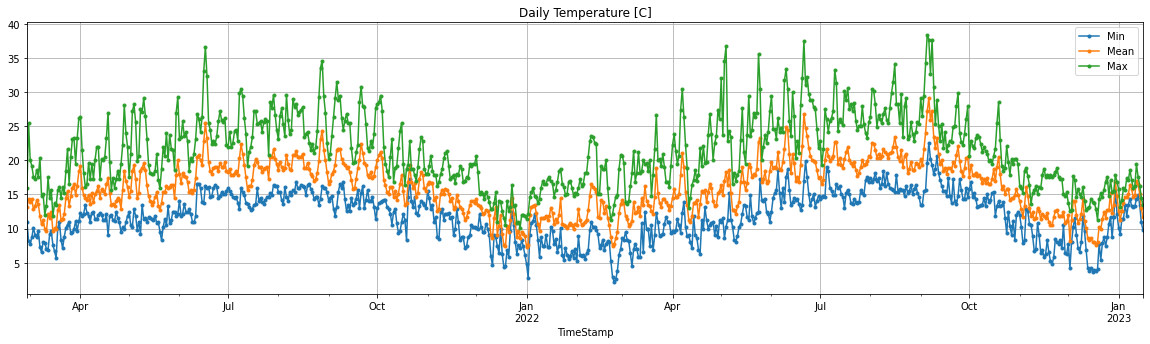

In [18]:
axs = dailyTemp.plot(figsize=(20,5), grid=True, subplots=False, marker='.', title='Daily Temperature [C]')

In [ ]:
# fft (from https://stackoverflow.com/questions/48622933/python-performing-fft-on-csv-values-using-scipy-documentation)
import numpy as np
from numpy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt

temperatureSeries = sensorLog.filter(items=['Temp']).values.flatten() #numpy array format
dt = 15/(24*60) #time increment in unit of days (every 15 minutes)

fft = rfft(temperatureSeries)*dt
freq = rfftfreq(len(temperatureSeries),d=dt)

plt.figure(figsize=(20,5))
plt.xlim([0.1,5])
plt.ylim([0,1400])
plt.xlabel('[Period in Days]')
axs = plt.bar(freq, abs(fft), width=0.025)
#axs = plt.plot(freq, abs(fft))

In [ ]:
pressureSeries = sensorLog.filter(items=['Pressure']).values.flatten() #numpy array format

fft = rfft(pressureSeries)*dt
freq = rfftfreq(len(pressureSeries),d=dt)

plt.figure(figsize=(20,5))
plt.xlim([0.01, 3.1])
plt.ylim([0, 17000])
plt.xlabel('[Period in Days]')
axs = plt.bar(freq, abs(fft), width=0.025)

In [ ]:
freq

In [ ]:
#https://www.geeksforgeeks.org/get-the-index-of-maximum-value-in-dataframe-column/
print(sensorLog[['Temp']].idxmin(), sensorLog[['Temp']].idxmax())

In [ ]:
sensorLog.loc[today:today][['Temp']].idxmin()

In [ ]:
# create dataframe with time of minimum and maximum temperature by date
# adapted from https://stackoverflow.com/questions/29569365/how-to-obtain-the-distribution-of-idmax-idmin-in-timeseries-data
sensorLogByDate = sensorLog.groupby(sensorLog.index.date)
timeMinMaxTemp = DataFrame({'MinTemp_Time': sensorLogByDate['Temp'].idxmin().dt.time, 
                            'MaxTemp_Time': sensorLogByDate['Temp'].idxmax().dt.time})

In [ ]:
timeMinMaxTemp.tail(10)

In [ ]:
# plot the min/max temp times by date
minTemp_Time = to_datetime(timeMinMaxTemp.MinTemp_Time, format='%H:%M:%S') #.dt.time
maxTemp_Time = to_datetime(timeMinMaxTemp.MaxTemp_Time, format='%H:%M:%S') #.dt.time
plt.figure(figsize=(20,8))
plt.plot(timeMinMaxTemp.index, minTemp_Time, marker='*', linestyle='None')
plt.plot(timeMinMaxTemp.index, maxTemp_Time, marker='+', linestyle='None')
plt.grid()

https://stackoverflow.com/questions/58263983/how-to-plot-date-in-x-axis-time-in-y-axis-with-pandas-matplotlib-and-present-ti

(add also sunrise sunset times)

In [ ]:
minTemp_Time

In [ ]:
sensorLog.tail(50)